# Практическая задача (40 баллов)

В этой задаче мы будем сравнивать различные итерационные методы для решения систем, как модельных, так и настоящих больших и разреженных.

In [652]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg
import scipy.sparse.linalg as spla
import time
%matplotlib inline

## 1. Модельная плотная матрица (25 баллов)

Начнём с некоторой модельной плотной матрицы. Она будет симметричной положительно определённой, чтобы можно было применять все наши методы, однако собственные числа мы выберем так, чтобы получить довольно большое число обусловленности.

In [653]:
d = np.hstack([1 / np.arange(100, 0, -1), 10])
n = len(d)
Q, _ = np.linalg.qr(np.random.random((n, n)))
A = (Q * d) @ Q.T
b = np.random.random(n)

На всякий случай нарисуем сингулярные числа.

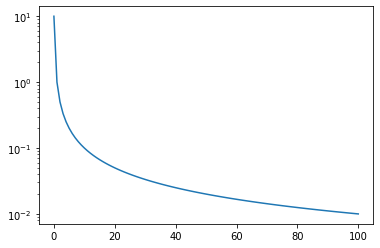

In [654]:
plt.plot(np.linalg.svd(A, compute_uv=False))
_ = plt.semilogy()

### a. Метод простой итерации (8 баллов)

Реализуйте функцию, которая обобщает все варианты метода простой итерации. За это обобщение отвечает параметр `get_dx` &mdash; функция, принимающая невязку $r_k$ и возвращающая вектор $\Delta x \equiv x_{k+1} - x_k$.
Также у функции есть параметр `tol`, соответствующий целевой относительной невязке, то есть величине $\|r_k\|_2/\|b\|_2$.
Наконец, параметр `debug` нужен, чтобы контролировать дебажный вывод. Если передан `debug=True`, на каждой итерации нужно печатать (в свободной форме) номер итерации, относительную невязку и всё, что ещё сочтёте интересным.

В выходном параметре `residual_norms` необходимо вернуть список относительных величин невязок для каждой итерации.

In [655]:
def simple_iteration(A, b, get_dx, x0=None, tol=1e-5, max_iter=None, debug=False):
    """
        Input
            A: dense or sparse square matrix
            b: right part of appropriate size
            get_dx: function computing correction to current solution from current residualresidue
            x0: initial guess for solution
            tol: relative residualresidue to achieve
            max_iter: if specified, no more that this number of iterations will be performed
            debug: if True, output iteration no. and relative residualresidue norm (||r||_2/||b||_2) at each iteration
            
        Output
            x: found approximate solution
            residual_norms: relative residualresidue norms at each iteration
    """
    b_norm = la.norm(b)
    xk = x0
    if not xk:
        xk = np.zeros(b.shape)
    rk = b - A @ xk
    rk_norm = la.norm(rk)
    residual_norms = [rk_norm / b_norm]
    k = 0
    while rk_norm > tol * b_norm:
        if max_iter and k >= max_iter:
            break
        xk += get_dx(rk)
        rk = b - A @ xk
        rk_norm = la.norm(rk)
        residual_norms.append(rk_norm / b_norm)
        if debug:
            print("iteration number: ", k)
            print("residual residue: ", rk_norm / b_norm)
        k += 1
    return xk, residual_norms

Используем также вспомогательную функцию, которая будет запускать солвер, печатать время работы и рисовать график сходимости.

In [656]:
def run_solver(solver, A, b, make_get_dx, **kwargs):
    start = time.time()
    get_dx = make_get_dx()
    get_dx_time = time.time()
    x, rs = solver(A, b, get_dx, **kwargs)
    finish = time.time()
    print("Runtime: {:4.2f} secs ({:4.2f} preparation + {:4.2f} iters)".format(
        finish - start,
        get_dx_time - start,
        finish - get_dx_time,
    ))
    if not rs:
        return None, finish - start
    line, = plt.plot(rs)
    plt.xlabel("Iteration no.")
    plt.ylabel("Relative residualresidue")
    _ = plt.semilogy()
    return line, finish - start

### b. Конкретные вариации метода простой итерации

Будем запускать известные нам варианты метода простой итерации.

##### Метод Ричардсона (3 балла)
Начнём с метода Ричардсона. Реализуйте функцию `make_richardson_get_dx(A, tau)`, которая возвращает функцию, соответствующую методу Ричардсона (Richardson iteration) с фиксированным параметром $\tau$.

In [657]:
def make_richardson_get_dx(A, tau):
    """
        Input
            A: square matrix
            tau: parameter of Richardson iteration

        Output
            get_dx: function mapping r to Δx corresponding to Richardson iteration
    """
    return lambda r: tau * r

Помня, что старшее и младшее собственные (и сингулярные) числа матрицы $A$ равны $10$ и $10^{-2}$ соответственно,
выберите 4 разных варианта для $\tau$ из интервала, в котором гарантируется сходимость метода, включая оптимальное значение $\tau$. Прокомментируйте полученный результат.

***Решение:***  
Сходимость гарантированна для любого $x_0$ на интервале $0 < \tau < \frac{2}{\lambda_1} = 0.2$. При этом оптимальное значение $\tau_{opt} = \frac{2}{\lambda_1 + \lambda_2} = \frac{2}{10 + 0.01}$.  
Поэтому возьмем значения $\tau$ равные $0.05$, $0.15$, $\frac{2}{10 + 0.01}$, $\frac{2}{10 + 0.001}$.

Runtime: 0.28 secs (0.00 preparation + 0.28 iters)
Runtime: 0.13 secs (0.00 preparation + 0.13 iters)
Runtime: 0.12 secs (0.00 preparation + 0.12 iters)
Runtime: 0.17 secs (0.00 preparation + 0.17 iters)


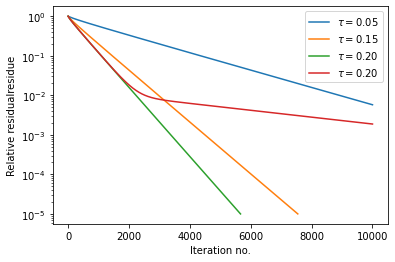

In [658]:
taus = [0.05, 0.15, 2 / (10 + 0.01), 2 / (10 + 0.001)]
lines = []
labels = []
for tau in taus:
    line, _ = run_solver(simple_iteration, A, b, lambda: make_richardson_get_dx(A, tau), max_iter=10000)
    lines.append(line)
    labels.append("$\\tau = {:4.2f}$".format(tau))
_ = plt.legend(lines, labels)

***Комментарий:***  
Мы видим постепенное ускорение сходимости при переходе от $\tau = 0.05$ к оптимальному значению $\tau_{opt} = \frac{2}{10 + 0.01}$. А при дальнейшем увеличении до $\tau = \frac{2}{10 + 0.001}$ мы видим резкое увеличение числа итераций с изменением характера сходимости: сначала скорость уменьшения относительной невязки примерно похожа на случай $\tau_{opt}$, а затем она резко уменьшается и становится меньше всех остальных.

Также попробуйте 1 вариант вне интервала, в котором гарантируется сходимость. Например, отступите от границы интервала на 0.01. Прокомментируйте полученный результат.

Runtime: 0.00 secs (0.00 preparation + 0.00 iters)


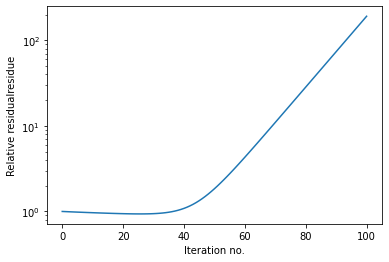

In [659]:
outsider_tau = 0.2 + 0.01
_ = run_solver(simple_iteration, A, b, lambda: make_richardson_get_dx(A, outsider_tau), max_iter=100)

***Комментарий:***  
Мы видим, что при выходе $\tau$ из интервала сходимости относительные невязки возрастают по итерациям, а значит метод при таком $\tau$ действительно не сходится.

##### Метод Якоби (3 балла)
Реализуйте функцию `make_jacobi_get_dx(A)`, которая возвращает функцию, соответствующую методу Якоби (то есть $g_{\mathrm{JAC}}(r) = \mathrm{diag}(A)^{-1}r$).

In [660]:
def make_jacobi_get_dx(A):
    """
        Input
            A: square matrix

        Output
            get_dx: function mapping r to Δx corresponding to Jacobi method
    """
    return lambda r: np.diag(1. / np.diag(A)) @ r

Запустим метод на нашей матрице. Объясните (неформально) полученный результат.

Runtime: 0.04 secs (0.00 preparation + 0.04 iters)


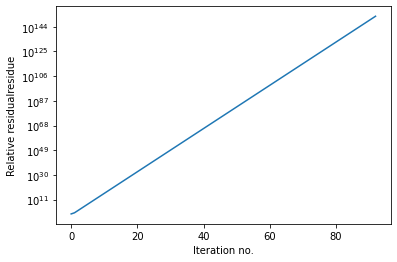

In [661]:
_ = run_solver(simple_iteration, A, b, lambda: make_jacobi_get_dx(A), max_iter=100)

***Объяснение:***  
Метод Якобы сходится для любого $x_0$, если матрица обладает свойством строгого диагонального преобладания, в остальных случаях сходимость не гарантированна. Мы генерировали матрицу так, что в ней скорее всего этого преобладания нет, а значит метод Якоби может разойтись, что он собственно и делает.

##### Метод Гаусса-Зейделя (3 балла)

Реализуйте функцию `make_gauss_seidel_get_dx(A)`, которая возвращает функцию `get_dx`, соответствующую методу Гаусса-Зейделя.

In [662]:
def make_gauss_seidel_get_dx(A):
    """
        Input
            A: square matrix

        Output
            get_dx: function mapping r to Δx corresponding to Gauss--Seidel method
    """
    return lambda r: scipy.linalg.solve_triangular(np.tril(A), r, lower=True)

Запустим метод.

Runtime: 0.89 secs (0.00 preparation + 0.89 iters)


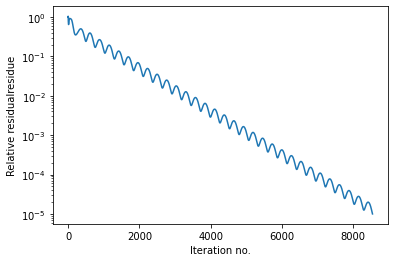

In [663]:
_ = run_solver(simple_iteration, A, b, lambda: make_gauss_seidel_get_dx(A))

##### Метод скорейшего спуска (3 балла)

Реализуйте функцию `make_steepest_descent_get_dx(A)`, которая возвращает функцию, соответствующую методу скорейшего спуска.

In [664]:
def make_steepest_descent_get_dx(A):
    """
        Input
            A: square matrix

        Output
            get_dx: function mapping r to Δx corresponding to steepest descent method
    """
    return lambda r: (r.T @ r) / (r.T @ A @ r) * r

Запустим метод скорейшего спуска.

Runtime: 0.12 secs (0.00 preparation + 0.12 iters)


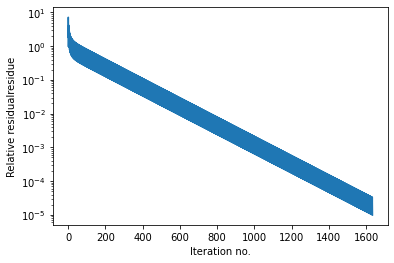

In [665]:
_ = run_solver(simple_iteration, A, b, lambda: make_steepest_descent_get_dx(A))

##### Метод сопряжённых градиентов (5 баллов)

Реализуйте обёртку над функцией `scipy.sparse.linalg.cg`. Набор параметров почти совпадает с функцией `simple_iteration`, за исключением некоторых деталей.
 1. Третий параметр называется `preconditioner` вместо `get_dx`, но играет похожую роль. Он должен редставлять собой объект класса [LinearOperator](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html). Такие объекты имеют `.shape` и умеют делать умножение на вектор справа с помощью операции `@`. Этот параметр нужно передать в `scipy.sparse.linalg.cg`. В случае, когда он не None, будет запускаться [предобусловленный метод сопряжённых градиентов](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_preconditioned_conjugate_gradient_method).
 2. Есть параметр `compute_residual`, отвечающий за необходимость вычислять относительные невязки (это вычисление требует дополнительного матрично-векторного умножения, поэтому увеличивает трудоёмкость). Если `compute_residual == False`, возвращаемый список `residual_norms` должен быть пуст.
 
При написании данной функции пользуйтесь [документацией](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html#scipy.sparse.linalg.cg) для `scipy.sparse.linalg.cg`. Особенно обратите внимание на параметр `callback`, он вам точно понадобится.

In [666]:
def conjugate_gradients(A, b, preconditioner=None, x0=None, tol=1e-5, max_iter=None, debug=False, compute_residual=True):
    """
        Input
            A: dense or sparse square matrix
            b: right part of equation
            preconditioner: scipy.sparse.linalg.LinearOperator
            x0: initial guess for solution
            tol: relative residual to achieve
            max_iter: if specified, no more that this number of iterations will be performed
            debug: if True, output iteration no. and relative residual norm (||r||_2/||b||_2) at each iteration
            compute_residual: whether to compute and output relative residualresidue norms

        Output
            x: found approximate solution
            residual_norms: relative residual norms at each iteration (empty if compute_residualresidues=False)
    """
    residual_norms = []
    if compute_residual: 
        b_norm = la.norm(b)
        def func(xk):
            if debug:
                print("xk: ", xk)
                print("residual residue: ", la.norm(b - A @ xk) / b_norm)
            residual_norms.append(la.norm(b - A @ xk) / b_norm)
        x, _ = spla.cg(A, b, x0=x0, tol=tol, M=preconditioner, maxiter=max_iter, callback=lambda xk: func(xk))  
    else:
        x, _ = spla.cg(A, b, x0=x0, tol=tol, M=preconditioner, maxiter=max_iter)
    return x, residual_norms

Запустим метод сопряжённых градиентов на нашей задаче.

Runtime: 0.03 secs (0.00 preparation + 0.03 iters)


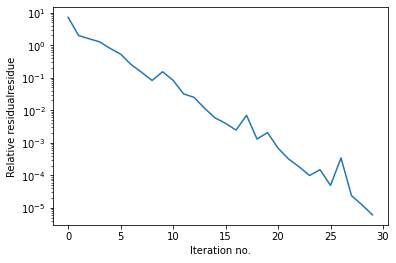

In [667]:
_ = run_solver(conjugate_gradients, A, b, lambda: None)

## 2. Применение к большим разреженным матрицам (15 баллов)

До сих пор больших проблем со сходимостью методов на тестовой матрице не возникало. Но в практических задачах могут возникать весьма неприятные матрицы. Давайте скачаем [файл G2_circuit.mat](https://sparse.tamu.edu/AMD/G2_circuit) (для удобства мы уже положили его в одну папку с данным ноутбуком; по ссылке можно ознакомиться с шаблоном разреженности матрицы и ее графом) с некоторой разреженной матрицей из коллекции разреженных матриц Флоридского университета https://sparse.tamu.edu. Отметим, что выбранная матрица соответствует некоторой задаче физической симуляции работы интегральной схемы (вероятно из процессора AMD).

На сайте коллекции можно не только сортировать матрицы по размерам и числу ненулевых элементов, но и фильтровать по разным свойствам. Например, упомянутая матрица является симметричной положительно определённой, что будет нам очень на руку.

Загрузим файл (он в матлабовском формате .mat, но scipy справится). Также выберем некоторый случайный вектор в качестве правой части.

In [668]:
import scipy.io
A = scipy.io.loadmat("data/G2_circuit.mat")["Problem"][0][0][2]
assert A.shape[0] == A.shape[1]
n = A.shape[0]
print("{} x {}, nnz: {}, density: {:.3}".format(n, n, A.nnz, A.nnz / float(n**2)))
b = np.random.random(n)

150102 x 150102, nnz: 726674, density: 3.23e-05


### a. Прямой солвер (3 балла)

Вычислите разреженное LU-разложение матрицы $A$, а затем с помощью него точное решение задачи $Ax = b$

In [669]:
def solve_exact(A, b):
    """
        Solve system Ax=b using sparse LU decomposition.

        Input
            A: square sparse matrix
            b: right part

        Output
            x: solution of Ax=b
    """
    return spla.splu(A).solve(b)

Замерим время работы прямого алгоритма. 

In [670]:
%timeit -r 1 -n 1 exact = solve_exact(A, b)

6.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Будем пробовать применять известные нам вариации метода простой итерации. Для начала запустим метод наискорейшего спуска.

Runtime: 3.86 secs (0.00 preparation + 3.86 iters)


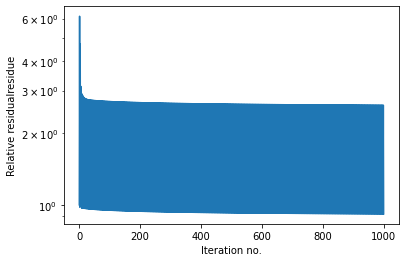

In [671]:
_ = run_solver(simple_iteration, A, b, lambda: make_steepest_descent_get_dx(A), max_iter=1000)

Судя по всему, матрица очень плохо обусловлена, и обычным методом простой итерации решить с ней систему будет нетривиально. Что же,  у нас есть серебряная пуля: метод сопряжённых градиентов. Запустите его!

Runtime: 5.45 secs (0.00 preparation + 5.45 iters)


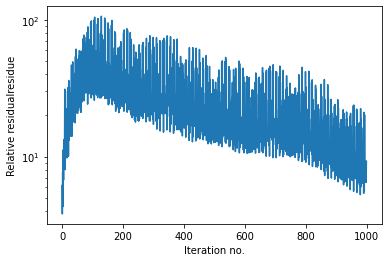

In [672]:
_ = run_solver(conjugate_gradients, A, b, lambda: None, max_iter=1000)

Кажется, матрица столь плохо обусловлена, что нас не спасает даже метод сопряжённых градиентов.
Есть ещё один шанс в таком случае &mdash; попробовать применить предобуславливатель.

### b. Предобусловленный метод сопряжённых градиентов (12 баллов)


##### Построение предобуславливателя (8 баллов)

Классический предобуславливатель для CG &mdash; это incomplete LU (ILU) decomposition, в котором по различным правилам отбрасываются возникающие заполнения. Реализуйте ILU-предобуславливатель, используя функцию `scipy.sparse.linalg.spilu`.
Параметры `fill_factor` и `drop_tol` нужны для настройки метода ILU. `fill_factor` отвечает за то, во сколько раз можно увеличить заполнение матрицы при вычислении неполного LU-разложения. `drop_tol` &mdash; это относительная величина элементов, меньше которой мы считаем их нулями. Эти параметры нужно передать в функцию `spilu`.

Не забудьте, что функция `make_ilu_prec` должна вернуть `scipy.sparse.linalg.LinearOperator`!

In [673]:
def make_ilu_prec(A, fill_factor=10, drop_tol=1e-4):
    """
        Input:
            A: sparse square matrix
            fill_factor: ILU fill ratio upper bound
            drop_tol: ILU drop tolerance
            
        Output:
            preconditioner: LinearOperator
    """
    lu = spla.spilu(A, drop_tol=drop_tol, fill_factor=fill_factor)
    return spla.LinearOperator(A.shape, matvec=lambda x: lu.solve(x))

Запустим метод на нашей матрице.

Runtime: 5.97 secs (2.09 preparation + 3.88 iters)


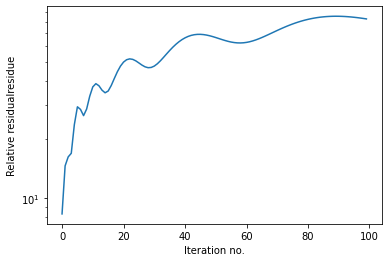

In [674]:
_ = run_solver(conjugate_gradients, A, b, lambda: make_ilu_prec(A), max_iter=100)

Метод расходится! Кажется, нас уже ничего не спасёт. Но ILU-предобуславливатель может быть достаточно чувствителен к параметрам `fill_factor` и `drop_tol`. Переберём параметры на сетке 3 на 3 `[10, 20, 50] x [1e-4, 1e-5, 1e-6]`.

Fill factor 10, drop tolerance 0.0001
Runtime: 5.79 secs (1.98 preparation + 3.81 iters)
Fill factor 10, drop tolerance 1e-05
Runtime: 5.92 secs (1.88 preparation + 4.05 iters)
Fill factor 10, drop tolerance 1e-06
Runtime: 5.66 secs (1.92 preparation + 3.74 iters)
Fill factor 20, drop tolerance 0.0001
Runtime: 7.90 secs (3.24 preparation + 4.66 iters)
Fill factor 20, drop tolerance 1e-05
Runtime: 8.00 secs (3.16 preparation + 4.84 iters)
Fill factor 20, drop tolerance 1e-06
Runtime: 8.18 secs (3.05 preparation + 5.13 iters)
Fill factor 50, drop tolerance 0.0001
Runtime: 7.49 secs (4.76 preparation + 2.73 iters)
Fill factor 50, drop tolerance 1e-05
Runtime: 12.73 secs (6.31 preparation + 6.42 iters)
Fill factor 50, drop tolerance 1e-06
Runtime: 8.00 secs (7.56 preparation + 0.44 iters)


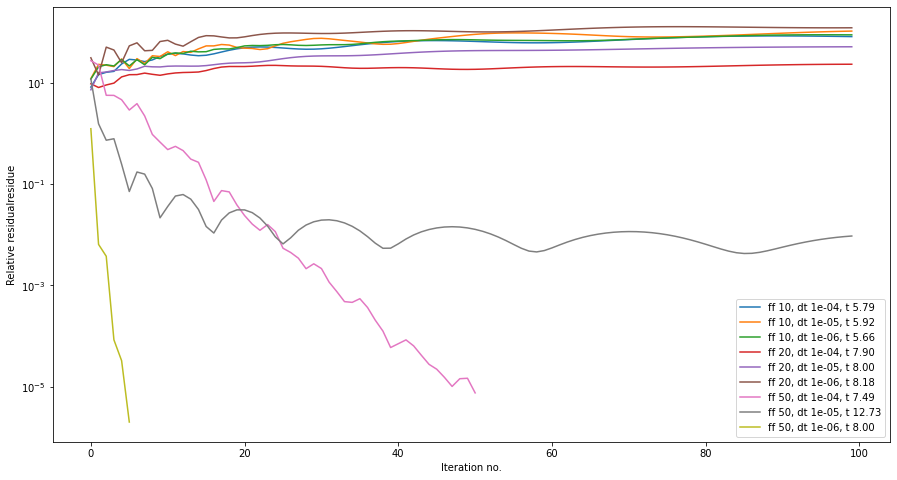

In [675]:
plt.figure(figsize=(15,8))
lines = []
labels = []
for ff in [10, 20, 50]:
    for dt in [1e-4, 1e-5, 1e-6]:
        print("Fill factor {}, drop tolerance {}".format(ff, dt))
        make_prec = lambda: make_ilu_prec(A, fill_factor=ff, drop_tol=dt)
        line, t = run_solver(conjugate_gradients, A, b, make_prec, max_iter=100)
        lines.append(line)
        labels.append("ff {}, dt {:2.0e}, t {:4.2f}".format(ff, dt, t))

_ = plt.legend(lines, labels)

Объясните, как согласуется наблюдаемый эффект немонотонности невязки с тем, что на каждой итерации подпространство Крылова увеличивается, и найденное приближение должно быть ближе к решению.

***Объяснение:***  
Эффект немонотонности невязки не противоречит увеличению на каждой итерации подпространства Крылова, так как мы знаем, что метод в итоге всё равно сойдется не более чем за количество шагов, равное размеру матрицы $A$, так как существует подпространство Крылова, содержащее решение.

##### Preconditioned CG vs sparse LU (4 баллов)

Для каких параметров метод сошёлся? Замерьте для всех сходящихся вариантов время работы без вычисления невязок (передайте `compute_residual=False` в функцию `run_solver`). В идеале вы должны (несильно, но всё же) победить по времени вычисления прямой метод (через полное LU), который вы использовали в начале раздела.

In [676]:
ff = 50
for dt in [1e-4, 1e-6]:
    print("Fill factor {}, drop tolerance {}".format(ff, dt))
    make_prec = lambda: make_ilu_prec(A, fill_factor=ff, drop_tol=dt)
    _ = run_solver(conjugate_gradients, A, b, make_prec, max_iter=100, compute_residual=False)

Fill factor 50, drop tolerance 0.0001
Runtime: 7.43 secs (4.74 preparation + 2.69 iters)
Fill factor 50, drop tolerance 1e-06
Runtime: 8.23 secs (7.77 preparation + 0.45 iters)


Победить прямой метод не удалось. Но мы были близки!